In [1]:
#pip install seaborn

In [2]:
#import tensorflow as tf

In [3]:
#pip install scikit-learn

In [4]:
#pip install tensorflow_datasets

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import scipy.sparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy as np
from datetime import datetime
import tensorflow_datasets as tfds
import IPython
import IPython.display

Download the data from the github
- Set the start and end date for the data
- Set the data directory where the downloaded datasets are stored

In [6]:
#def download_economic_data():
  #  dl_manager = tfds.download.DownloadManager(download_dir = '/tmp/economic_recovery', 
   #                                            extract_dir='/tmp/economic_recovery')
    #path = dl_manager.download_and_extract(
     #   'https://github.com/OpportunityInsights/EconomicTracker/tree/main.zip'
    #)
    #data_dir = path + '/EconomicTracker-main/data/'
    #return data_dir


In [7]:

start_date = '2020-03-07'
end_date = '2021-03-06'
#data_dir = download_economic_data()
data_dir = 'data/'
state = 26
IPython.display.clear_output()
print('data dir:',data_dir)

data dir: data/


The function below does the following:

- Read the csv file into Pandas dataframe
- If state is passed, then filter the records for the state (will be using data for Michigan only)
- The data contains three columns for the date. year, month, and day. So, concatenates them and convert it to datetime type
- If a column list is passed, then select only those columns from the dataframe, otherwise use the entire column list available
- If a column contains '.', it will be converted to '0.0'
- The datatype of the columns are converted to float
- Interpolate missing data if any
- Select only the date range passed and return to the caller

In [8]:
def prepare_data(csv_file, start_date=start_date, end_date=end_date, day=None, 
                 state=state, selected_cols=[], interpolate=True):
    df = pd.read_csv(data_dir + csv_file)
    if (state is not None):
        df = df[df['statefips'] == state] 
        
    if (day is None):
        day = 'day'
        
    df['date'] = df[['year', 'month', day]].apply(lambda s : datetime(*s),axis = 1)
    df.drop(('year'), axis=1, inplace=True)
    df.drop(('month'), axis=1, inplace=True)
    df.drop((day), axis=1, inplace=True)
    df.index = pd.DatetimeIndex(df['date'])
    df.sort_index()

    if (len(selected_cols) > 0):
        df = df[selected_cols]
    if (interpolate):
        df = df.reindex(pd.date_range(start_date, end_date), fill_value="NaN")
    df.drop(('date'), axis=1, inplace=True, errors='ignore')
    
    str_cols = df.select_dtypes(include=['object']).columns
    df[str_cols] = df[str_cols].replace({'.':'0.0'})
    
    df = df.astype(float)
    df = df.interpolate(method='linear', axis=0).ffill().bfill()
    df = df[df.index >= start_date] 
    df = df[df.index <= end_date] 
    return df

In [9]:
#03/13/2021

selected_cols=['initclaims_count_regular', 'contclaims_count_regular', 'initclaims_count_combined','contclaims_count_combined',
              'contclaims_count_pua']
ui_claims = prepare_data('UI Claims - State - Weekly.csv', day='day_endofweek', selected_cols=selected_cols, interpolate=True)
ui_claims.head()
#print(ui_claims)

,initclaims_count_regular,contclaims_count_regular,initclaims_count_combined,contclaims_count_combined,contclaims_count_pua
2020-03-07,5150.000000,77661.0,5150.000000,77661.0,0.0
2020-03-08,5176.857143,77389.0,5176.857143,77389.0,0.0
2020-03-09,5203.714286,77117.0,5203.714286,77117.0,0.0
2020-03-10,5230.571429,76845.0,5230.571429,76845.0,0.0
2020-03-11,5257.428571,76573.0,5257.428571,76573.0,0.0


In [10]:
#03/09/2021

selected_cols=['bg_posts_ss60', 'bg_posts_ss70','bg_posts_ss55', 'bg_posts_ss65']
burning_glass = prepare_data('Burning Glass - State - Weekly.csv', start_date='2020-03-06', selected_cols=selected_cols, day='day_endofweek', interpolate=True)
burning_glass.tail()

,bg_posts_ss60,bg_posts_ss70,bg_posts_ss55,bg_posts_ss65
2021-03-02,-0.093543,-0.121143,-0.054843,0.074086
2021-03-03,-0.103029,-0.126429,-0.055029,0.058857
2021-03-04,-0.112514,-0.131714,-0.055214,0.043629
2021-03-05,-0.122000,-0.137000,-0.055400,0.028400
2021-03-06,-0.122000,-0.137000,-0.055400,0.028400


In [11]:
#03/12/2021

selected_cols=['case_count', 'death_count', 'test_count']
covid_mi_daily = prepare_data('COVID - State - Daily.csv', selected_cols=selected_cols)
covid_mi_daily.head()
#covid_mi_daily = covid_mi_daily.resample('W').sum() 
#to aggregate the daily data into weekly
#covid_mi_daily.head(40).plot()
#covid_mi_daily.resample('W').mean().head(9).plot()
#, 'test_count'

,case_count,death_count,test_count
2020-03-07,0.0,0.0,4.0
2020-03-08,0.0,0.0,5.0
2020-03-09,0.0,0.0,6.0
2020-03-10,0.0,0.0,8.0
2020-03-11,1.0,0.0,14.0


In [12]:
#03/12/2021

selected_cols=['revenue_ss60', 'revenue_ss70', 'merchants_ss40', 'merchants_ss65', 'merchants_retail']
revenue_daily = prepare_data('Womply - State - Daily.csv', selected_cols=selected_cols)
#revenue_daily = revenue_daily.resample('W').sum()
revenue_daily.head()
#revenue_daily.head(40).plot()
#revenue_daily.resample('W').mean().head(9).plot()

,revenue_ss60,revenue_ss70,merchants_ss40,merchants_ss65,merchants_retail
2020-03-07,0.0533,-0.0363,-0.00762,-0.0366,-0.00426
2020-03-08,0.1000,-0.0314,-0.00794,-0.0377,-0.00428
2020-03-09,0.0691,-0.0333,-0.00901,-0.0379,-0.00630
2020-03-10,0.0255,-0.0396,-0.00761,-0.0459,-0.00489
2020-03-11,0.0270,-0.0455,-0.00843,-0.0471,-0.00652


In [13]:
#03/12/2021

selected_cols=['spend_acf', 'spend_hcs', 'spend_aer', 'spend_apg']
spend_daily = prepare_data('Affinity - State - Daily.csv', selected_cols=selected_cols)
#spend_daily = spend_daily.resample('W').sum()
spend_daily.head()

,spend_acf,spend_hcs,spend_aer,spend_apg
2020-03-07,-0.02470,-0.04850,-0.0301,-0.06240
2020-03-08,-0.02630,-0.04410,-0.0061,-0.02940
2020-03-09,-0.02080,-0.08960,-0.0261,-0.03220
2020-03-10,-0.00693,0.04930,-0.0433,-0.00284
2020-03-11,-0.00897,0.00343,-0.0713,-0.01740


In [14]:
#04/01/2021

selected_cols=['emp_combined', 'emp_combined_ss40', 'emp_combined_ss60', 'emp_combined_ss70', 'emp_combined_ss65']
employment_daily = prepare_data('Employment - State - Daily.csv', selected_cols=selected_cols)
#employment_daily = employment_daily.resample('W').sum()
employment_daily.head()

,emp_combined,emp_combined_ss40,emp_combined_ss60,emp_combined_ss70,emp_combined_ss65
2020-03-07,0.00746,0.001040,-0.01070,0.0276,0.00657
2020-03-08,0.00741,0.000871,-0.01020,0.0266,0.00691
2020-03-09,0.00734,0.000659,-0.00958,0.0252,0.00730
2020-03-10,0.00716,0.000342,-0.00905,0.0231,0.00761
2020-03-11,0.00677,-0.000114,-0.00867,0.0200,0.00773


In [15]:
#04/01/2021

#selected_cols=['engagement', 'badges', 'break_engagement', 'break_badges']
#zearn_weekly = prepare_data('Zearn - State - Weekly.csv', day = 'day_endofweek', selected_cols=selected_cols)
#zearn_weekly.tail()

In [16]:
#04/01/2021

selected_cols=['gps_retail_and_recreation', 'gps_grocery_and_pharmacy', 'gps_transit_stations', 'gps_workplaces', 'gps_away_from_home']
mobility = prepare_data('Google Mobility - State - Daily.csv', selected_cols=selected_cols)
#mobility = mobility.resample('W').sum()
mobility.head(10)

,gps_retail_and_recreation,gps_grocery_and_pharmacy,gps_transit_stations,gps_workplaces,gps_away_from_home
2020-03-07,0.10700,0.0471,0.10700,0.02570,0.01560
2020-03-08,0.10700,0.0486,0.09430,0.02570,0.01560
2020-03-09,0.10300,0.0486,0.09140,0.02570,0.01390
2020-03-10,0.10100,0.0457,0.08710,0.02290,0.01250
2020-03-11,0.09570,0.0586,0.08000,0.02290,0.01090
2020-03-12,0.09140,0.0929,0.07000,0.02000,0.00800
2020-03-13,0.08140,0.1410,0.05570,0.01000,0.00385
2020-03-14,0.04290,0.1490,0.02860,0.00143,-0.01120
2020-03-15,0.00286,0.1470,-0.00286,-0.01140,-0.02570
2020-03-16,-0.03000,0.1760,-0.03140,-0.04430,-0.04090


In [17]:
result = pd.concat([ui_claims, burning_glass, covid_mi_daily, revenue_daily, employment_daily, spend_daily, mobility], axis=1, join='inner')
# nit using employment_daily and zearn_weekly, 
result.tail()
##, join='inner'

,initclaims_count_regular,contclaims_count_regular,initclaims_count_combined,contclaims_count_combined,contclaims_count_pua,bg_posts_ss60,bg_posts_ss70,bg_posts_ss55,bg_posts_ss65,case_count,...,emp_combined_ss65,spend_acf,spend_hcs,spend_aer,spend_apg,gps_retail_and_recreation,gps_grocery_and_pharmacy,gps_transit_stations,gps_workplaces,gps_away_from_home
2021-03-02,11452.428571,169619.714286,15359.142857,694392.285714,342022.714286,-0.093543,-0.121143,-0.054843,0.074086,613391.0,...,0.0121,-0.121,-0.1380,-0.1400,0.0655,-0.174,-0.0943,-0.273,-0.229,-0.0952
2021-03-03,11437.571429,166754.285714,15297.857143,749795.714286,382343.285714,-0.103029,-0.126429,-0.055029,0.058857,614731.0,...,0.0121,-0.136,-0.1520,-0.0731,0.0676,-0.163,-0.0857,-0.264,-0.229,-0.0936
2021-03-04,11422.714286,163888.857143,15236.571429,805199.142857,422663.857143,-0.112514,-0.131714,-0.055214,0.043629,616099.0,...,0.0121,-0.144,-0.1440,-0.0315,0.0831,-0.159,-0.0843,-0.263,-0.229,-0.0936
2021-03-05,11407.857143,161023.428571,15175.285714,860602.571429,462984.428571,-0.122000,-0.137000,-0.055400,0.028400,617541.0,...,0.0121,-0.121,-0.0104,0.0308,0.1160,-0.156,-0.0829,-0.261,-0.229,-0.0936
2021-03-06,11393.000000,158158.000000,15114.000000,916006.000000,503305.000000,-0.122000,-0.137000,-0.055400,0.028400,619020.0,...,0.0121,-0.103,-0.0102,0.0550,0.1250,-0.153,-0.0814,-0.260,-0.227,-0.0936


In [18]:
result.shape

(365, 31)

## Performing Correlation and Heatmaps on the features columns to ascertain which to retain in the dataframe

<Figure size 1152x864 with 0 Axes>

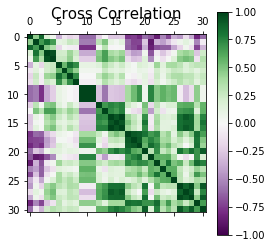

In [19]:
# Correlations among columns
plt.figure(figsize=(16,12))
plt.matshow(result.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('Cross Correlation', size=15)
plt.colorbar()
plt.show()

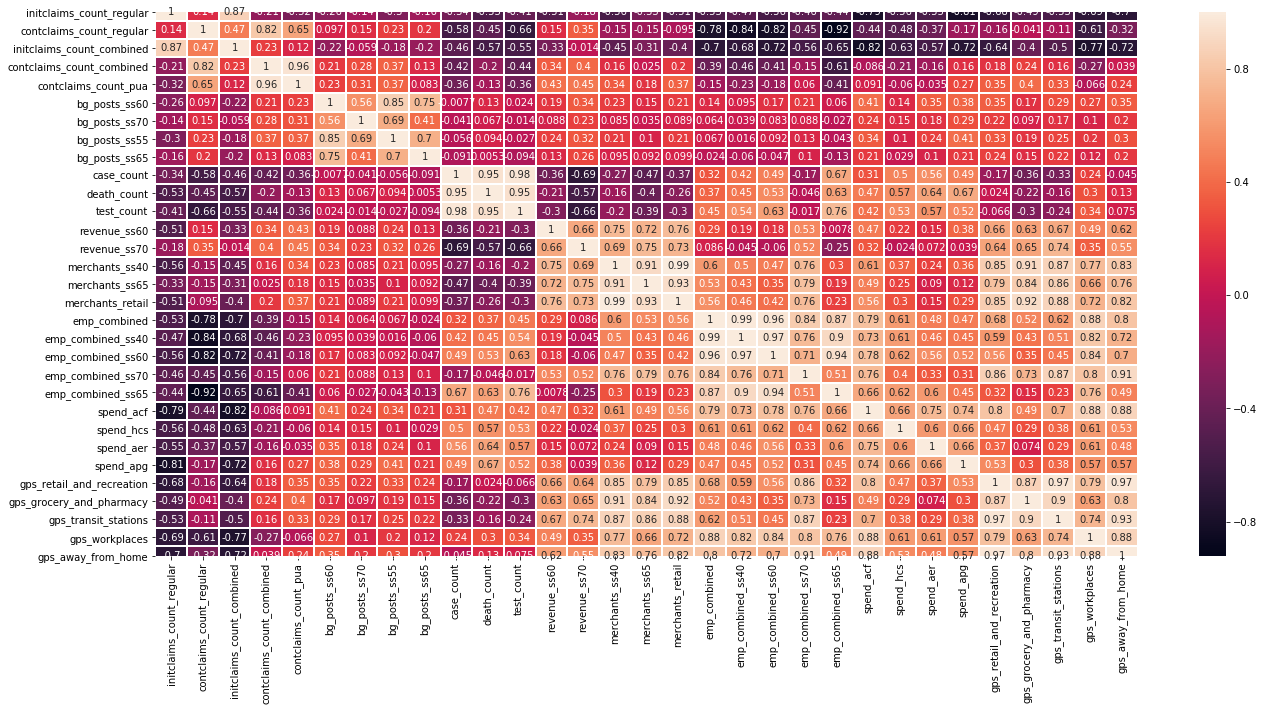

In [20]:
import seaborn as sns
plt.figure(figsize=(22,10))
sns.heatmap(result.corr(), linewidths=1, annot=True)

## Dropping off the highly correlated features and retaining the appropriate ones with corr >= 0.85

In [21]:
result1 = result.drop(['initclaims_count_regular', 'contclaims_count_pua', 'bg_posts_ss55', 'emp_combined', 'merchants_ss40','merchants_retail', 
                         'emp_combined_ss65', 'emp_combined_ss40'], axis = 1)
result1.shape
#'gps_away_from_home',, 'gps_transit_stations', 'test_count',

(365, 23)

## Features remaining after dropping ones that were highly correlated

In [22]:
result1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2020-03-07 to 2021-03-06
Freq: D
Data columns (total 23 columns):
contclaims_count_regular     365 non-null float64
initclaims_count_combined    365 non-null float64
contclaims_count_combined    365 non-null float64
bg_posts_ss60                365 non-null float64
bg_posts_ss70                365 non-null float64
bg_posts_ss65                365 non-null float64
case_count                   365 non-null float64
death_count                  365 non-null float64
test_count                   365 non-null float64
revenue_ss60                 365 non-null float64
revenue_ss70                 365 non-null float64
merchants_ss65               365 non-null float64
emp_combined_ss60            365 non-null float64
emp_combined_ss70            365 non-null float64
spend_acf                    365 non-null float64
spend_hcs                    365 non-null float64
spend_aer                    365 non-null float64
spend_apg         

In [23]:
#result1.to_csv(r'CleanedResults.csv')